## Batch correction titration experiments

In [1]:
from pathlib import Path
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
# set results directory
base_results_dir = Path(cfg.results_dirs['mutation'],
                        'bc_titration_small')

# which gene to plot
plot_genes = ['TP53', 'KRAS', 'EGFR', 'TTN', 'HERC2', 'XIST']

# how many features to plot
plot_feats = 10

In [3]:
def load_single_model(results_file):
    results_filename = Path(results_file).stem
    if results_filename[0] == '.':
        return pd.DataFrame()
    if ('classify' not in results_filename or 
        'metrics' not in results_filename):
        return pd.DataFrame()
    try:
        titration_ratio = int(float(results_filename.split('_')[5].replace('t', '')))
    except ValueError:
        titration_ratio = None
    results_df = pd.read_csv(results_file, sep='\t')
    if titration_ratio is not None:
        results_df['titration_ratio'] = titration_ratio
    return results_df
    
def load_all_models(base_results_dir, genes, num_feats, models):
    results_df = pd.DataFrame()
    for gene in genes:
        for model in models:
            results_dir = Path(base_results_dir,
                               '{}_{}'.format(model, num_feats),
                               'gene',
                               gene)
            for fname in glob.glob(
                str(results_dir /'*_classify_*metrics*')
            ):
                try:
                    model_results_df = load_single_model(fname)
                    model_results_df['model'] = model
                    model_results_df['num_feats'] = num_feats
                except FileNotFoundError:
                    model_results_df = pd.DataFrame()
                results_df = pd.concat((results_df, model_results_df))
    return results_df

In [4]:
results_df = load_all_models(base_results_dir, plot_genes, plot_feats,
                             models=['linear_bc', 'nonlinear_bc'])
print(results_df.shape)
results_df.head()

(14112, 11)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,titration_ratio,model,num_feats
0,0.51695,0.49147,TP53,expression,shuffled,1,train,0,8,linear_bc,10
1,0.51459,0.49339,TP53,expression,shuffled,1,test,0,8,linear_bc,10
2,0.58476,0.53493,TP53,expression,shuffled,1,cv,0,8,linear_bc,10
3,0.56460,0.53272,TP53,expression,shuffled,1,train,1,8,linear_bc,10
4,0.52474,0.51309,TP53,expression,shuffled,1,test,1,8,linear_bc,10


In [5]:
baseline_df = load_all_models(base_results_dir, plot_genes, plot_feats,
                             models = ['linear', 'nonlinear'])
print(baseline_df.shape)
baseline_df.head()

(576, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,model,num_feats
0,0.51588,0.49278,TP53,expression,shuffled,42,train,0,linear,10
1,0.49623,0.47959,TP53,expression,shuffled,42,test,0,linear,10
2,0.50234,0.47322,TP53,expression,shuffled,42,cv,0,linear,10
3,0.52337,0.49335,TP53,expression,shuffled,42,train,1,linear,10
4,0.49890,0.49819,TP53,expression,shuffled,42,test,1,linear,10


TP53
linear, signal mean: 0.731
nonlinear, signal mean: 0.779
linear, shuffled mean: 0.477
nonlinear, shuffled mean: 0.479
KRAS
linear, signal mean: 0.524
nonlinear, signal mean: 0.578
linear, shuffled mean: 0.260
nonlinear, shuffled mean: 0.252
EGFR
linear, signal mean: 0.215
nonlinear, signal mean: 0.306
linear, shuffled mean: 0.129
nonlinear, shuffled mean: 0.127
TTN
linear, signal mean: 0.703
nonlinear, signal mean: 0.696
linear, shuffled mean: 0.330
nonlinear, shuffled mean: 0.323
HERC2
linear, signal mean: 0.201
nonlinear, signal mean: 0.152
linear, shuffled mean: 0.095
nonlinear, shuffled mean: 0.088
XIST
linear, signal mean: 0.268
nonlinear, signal mean: 0.234
linear, shuffled mean: 0.119
nonlinear, shuffled mean: 0.121


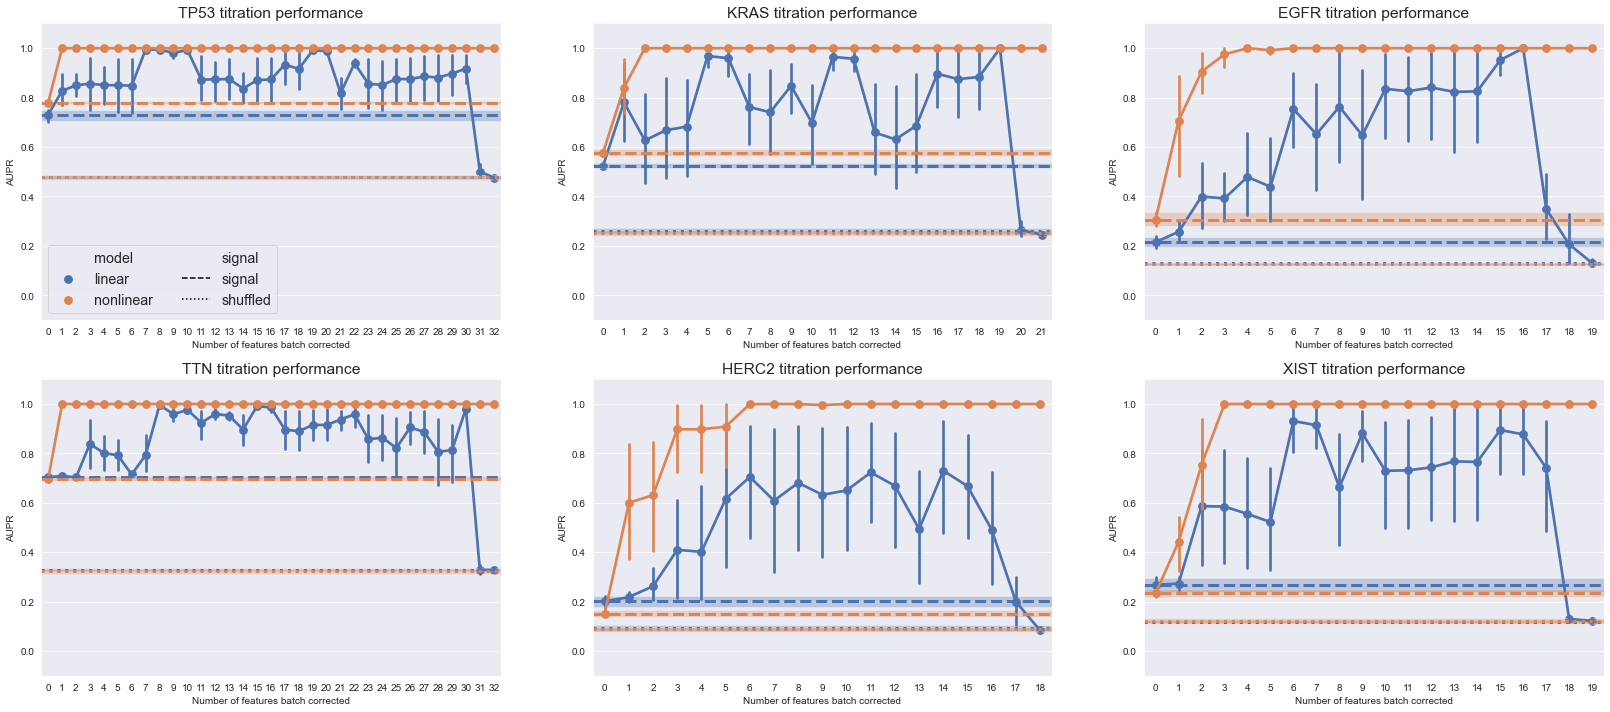

In [6]:
sns.set({'figure.figsize': (28, 12)})
fig, axarr = plt.subplots(2, 3)

with sns.plotting_context('notebook', font_scale=1.3):
    for ix, gene in enumerate(plot_genes):
        print(gene)
        ax = axarr[ix // 3, ix % 3]
        plot_df = results_df[
            (results_df.identifier == gene) &
            (results_df.signal == 'signal') &
            (results_df.data_type == 'test')
        ]
        sns.pointplot(data=plot_df, x='titration_ratio', y='aupr', hue='model', ax=ax)
        ax.set_xlabel('Number of features batch corrected')
        ax.set_ylim(-0.1, 1.1)
        ax.set_ylabel('AUPR')
        ax.set_title('{} titration performance'.format(gene))
        
        # plot signal and shuffled baseline, linear and nonlinear
        import itertools as it
        for signal, model in it.product(
            ('signal', 'shuffled'),
            ('linear', 'nonlinear')
        ):
            baseline_vals = baseline_df[
                (baseline_df.identifier == gene) &
                (baseline_df.data_type == 'test') &
                (baseline_df.model == model) &
                (baseline_df.signal == signal)
            ]['aupr'].values

            # get mean and plot as dotted line
            baseline_mean = np.mean(baseline_vals)
            color_ix = 1 if model == 'nonlinear' else 0
            style = '--' if signal == 'signal' else ':'
            ax.axhline(y=baseline_mean, linestyle=style, linewidth=3,
                       color=sns.color_palette()[color_ix])
            print('{}, {} mean: {:.3f}'.format(model, signal, baseline_mean))

            # get bootstrapped 95% CI, using seaborn method
            # plot as transparent shaded region
            baseline_ci = sns.utils.ci(
                sns.algorithms.bootstrap(baseline_vals,
                                         func=np.mean,
                                         n_boot=1000,
                                         units=None,
                                         seed=cfg.default_seed)
            )
            ax.axhspan(baseline_ci[0], baseline_ci[1], alpha=0.3,
                       facecolor=sns.color_palette()[color_ix])
            
            if ix == 0:
                from matplotlib.lines import Line2D
                custom_legend_lines = [
                    Line2D([0], [0], color='black', linestyle='--'),
                    Line2D([0], [0], color='black', linestyle=':')
                ]
                handles, labels = ax.get_legend_handles_labels()
                l = ax.legend(
                    [Line2D([0], [0], color='black', linestyle='--')] + handles +[Line2D([0], [0], color='black', linestyle='--')] + custom_legend_lines,
                    ['model'] + ['linear', 'nonlinear'] + ['signal'] + ['signal', 'shuffled']
                , ncol=2)
                l.legendHandles[0].set_visible(False)
                l.legendHandles[3].set_visible(False)
            else:
                ax.legend().set_visible(False)
            
        # plt.tight_layout()